This is a tutorial for R users that visualizes compounds present in the processed .hdf5 files. Functions are described in depth to allow easier modification for the specific use cases of the user.

# install and load libraries

In [1]:
install.packages("BiocManager")
BiocManager::install("rhdf5")

# load library
library(rhdf5)

## define functions

In [2]:
# Define a function called Load_umaia_data that takes a file path to an HDF5 file as its input.
Load_umaia_data = function(h5_file_path) {

  # Read the dataset stored at the "/X" path in the HDF5 file.
  # This likely contains the main data matrix.
  Data = h5read(h5_file_path, name = "/X")
  
  # Transpose the data matrix so that each row corresponds to a spot (e.g., spatial location)
  # and each column corresponds to a feature (e.g., a measured variable).
  Data = t(Data)
  
  # Read the X coordinates from the HDF5 file stored under the "/uns/x_coord" path.
  X = h5read(h5_file_path, name = "/uns/x_coord")
  
  # Read the Y coordinates from the file, stored under "/uns/y_coord".
  Y = h5read(h5_file_path, name = "/uns/y_coord")
  
  # Read the Z coordinates from the file, stored under "/uns/z_coord".
  Z = h5read(h5_file_path, name = "/uns/z_coord")
  
  # Combine the X, Y, and Z coordinates into a data frame called Meta_data.
  # This data frame will help reference the spatial metadata for each spot.
  Meta_data = data.frame(X = X, Y = Y, Z = Z)
  
  # Read the m/z (mass-to-charge ratio) identifiers from the HDF5 file under "/var".
  ID_col = h5read(h5_file_path, name = "/var")
  
  # Extract the actual values from the first element (or sub-field) of the read data.
  ID_col = ID_col$`0`
  
  # Rename the columns of the data matrix by prefixing each m/z identifier with "mz_".
  # This creates a clear label for each feature.
  colnames(Data) = paste0("mz_", ID_col)
  
  # Return a list containing two elements:
  # 1. Lipid_data: The transposed data matrix (spots x features).
  # 2. Meta_data: The spatial coordinates (X, Y, Z) for each spot.
  return(list(
    Lipid_data = Data,      # Matrix with rows as spots and columns as features.
    Meta_data  = Meta_data  # Data frame of spatial coordinates.
  ))
}

# Define a function called color_conversion that takes:
# - values: a vector of numeric values to be converted into colors,
# - palette: a function to generate a color palette (default: blue to red gradient),
# - n_breaks: the number of color intervals to create (default: 100),
# - value_range: an optional range to standardize the color mapping.
color_conversion <- function(values,
                             palette = colorRampPalette(c("blue", "green", "yellow", "red")),
                             n_breaks = 100,
                             value_range = NULL) {
  
  # If no specific value range is provided, compute the range from the provided values.
  # We consider only finite values and remove any NA values.
  if (is.null(value_range)) {
    value_range <- range(values[is.finite(values)], na.rm = TRUE)
  }
  
  # Create a sequence of breakpoints across the computed or given value range.
  # 'n_breaks + 1' breakpoints define 'n_breaks' intervals.
  breaks <- seq(value_range[1], value_range[2], length.out = n_breaks + 1)
  
  # Generate a vector of colors using the specified palette function,
  # with 'n_breaks' colors representing each interval.
  colors <- palette(n_breaks)
  
  # Bin the numeric values into intervals defined by 'breaks'.
  # The 'cut' function assigns each value to an interval (bin),
  # using 'include.lowest = TRUE' to include the smallest value.
  # The result is a numeric index for each bin.
  color_bins <- cut(values, breaks = breaks, include.lowest = TRUE, labels = FALSE)
  
  # Map each binned value to its corresponding color.
  # 'colors[color_bins]' retrieves the color based on the bin index.
  point_colors <- colors[color_bins]
  
  # Return the vector of colors corresponding to the original numeric values.
  return(point_colors)
}

Spatial_plot_single <- function(Lipid_data, 
                                Meta_data,
                                Feature = 1,
                                Selected_cut = 1,
                                global_value_range = NULL) {
  
  subset_idx <- Meta_data$X == Selected_cut
  plot_Z <- Meta_data$Z[subset_idx]
  plot_Y <- Meta_data$Y[subset_idx]
  
  # The intensities for the chosen feature
  feature_values <- Lipid_data[subset_idx, Feature]
  
  # Determine the color of each point
  point_colors <- color_conversion(feature_values,
                                   value_range = global_value_range)
  
  # We use the same approach as before to get a square-ish plot:
  delta_X <- max(plot_Z) - min(plot_Z)
  delta_Y <- max(plot_Y) - min(plot_Y)
  delta_max <- max(delta_X, delta_Y)
  
  x_min <- min(plot_Z) * 0.9
  x_max <- (min(plot_Z) + delta_max) * 1.05
  y_min <- min(plot_Y) * 0.9
  y_max <- (min(plot_Y) + delta_max) * 1.05
  
  # Base R plot
  plot(plot_Z,
       plot_Y,
       pch = 21,
       bg = point_colors,
       cex = 0.55, 
       lwd = 0.1,
       xlim = c(x_min, x_max),
       ylim = c(y_min, y_max),
       xlab = "Z",
       ylab = "Y",
       main = paste("Section =", Selected_cut, "\nFeature:", colnames(Lipid_data)[Feature])
  )
  
  # Return the bounding box used, in case you need it
  return(list(xlim = c(x_min, x_max), ylim = c(y_min, y_max)))
}


Spatial_plot <- function(Lipid_data, 
                         Meta_data,
                         Feature = 1,
                         Selected_cut = 1) {
  
  # 1. Subset rows where X == Selected_cut
  subset_idx <- Meta_data$X == Selected_cut
  
  # 2. Extract the relevant Z, Y for plotting and the intensities for coloring
  plot_Z <- Meta_data$Z[subset_idx]
  plot_Y <- Meta_data$Y[subset_idx]
  feature_values <- Lipid_data[subset_idx, Feature]
  
  # 3. Calculate axis ranges so plot is roughly square
  delta_X <- max(plot_Z) - min(plot_Z)
  delta_Y <- max(plot_Y) - min(plot_Y)
  delta_max <- max(delta_X, delta_Y)
  
  x_min <- min(plot_Z) * 0.9
  x_max <- (min(plot_Z) + delta_max) * 1.05
  y_min <- min(plot_Y) * 0.9
  y_max <- (min(plot_Y) + delta_max) * 1.05
  
  # 4. Convert intensities to colors
  point_colors <- color_conversion(feature_values)
  
  # 5. Plot
  plot(plot_Z,
       plot_Y,
       pch = 21,
       bg = point_colors,
       cex = 0.55, 
       lwd = 0.1,
       xlim = c(x_min, x_max),
       ylim = c(y_min, y_max),
       xlab = "Z",
       ylab = "Y",
       main = paste("Section =", Selected_cut, " | Feature:", colnames(Lipid_data)[Feature])
  )
}

Spatial_plot_multiple_subplots <- function(Lipid_data,
                                    Meta_data,
                                    Feature = 1,
                                    Selected_sections = c(1,2,3,4,5,6,7,8),
                                    use_global_scale = TRUE) {
  # 1) Optionally compute a global range of intensities across *all* these cuts
  global_range <- NULL
  if (use_global_scale) {
    # All indices across the selected cuts
    idx_all <- Meta_data$X %in% Selected_cuts
    all_values <- Lipid_data[idx_all, Feature]
    global_range <- range(all_values[is.finite(all_values)], na.rm = TRUE)
  }
  
  # 2) Set up 1 row by N columns (in your case, 8 columns)
  old_par <- par(mfrow = c(1, length(Selected_cuts)),
                 mar = c(2.5, 2.5, 2.5, 1),  # a bit less margin
                 oma = c(0, 0, 0, 0))       # outer margins
  on.exit(par(old_par), add = TRUE)
  
  # 3) Loop over each desired cut
  for (sc in Selected_cuts) {
    Spatial_plot_single(Lipid_data,
                        Meta_data,
                        Feature = Feature,
                        Selected_cut = sc,
                        global_value_range = global_range)
  }
  
  # The function doesn’t return anything in particular, 
  # but you could return e.g. the global_range if you like:
  # return(invisible(global_range))
}

## load data

In [3]:
# select the path of the .h5ad object
X = Load_umaia_data("processed24.h5ad")

# same the imaging data and the metadata
Lipid_data <- X$Lipid_data
Meta_data  <- X$Meta_data

## plotting
Create the plots - select the ID of the feature (argument "Feature") and select the set of sections that you want to visualize (argument "Selected_sections")

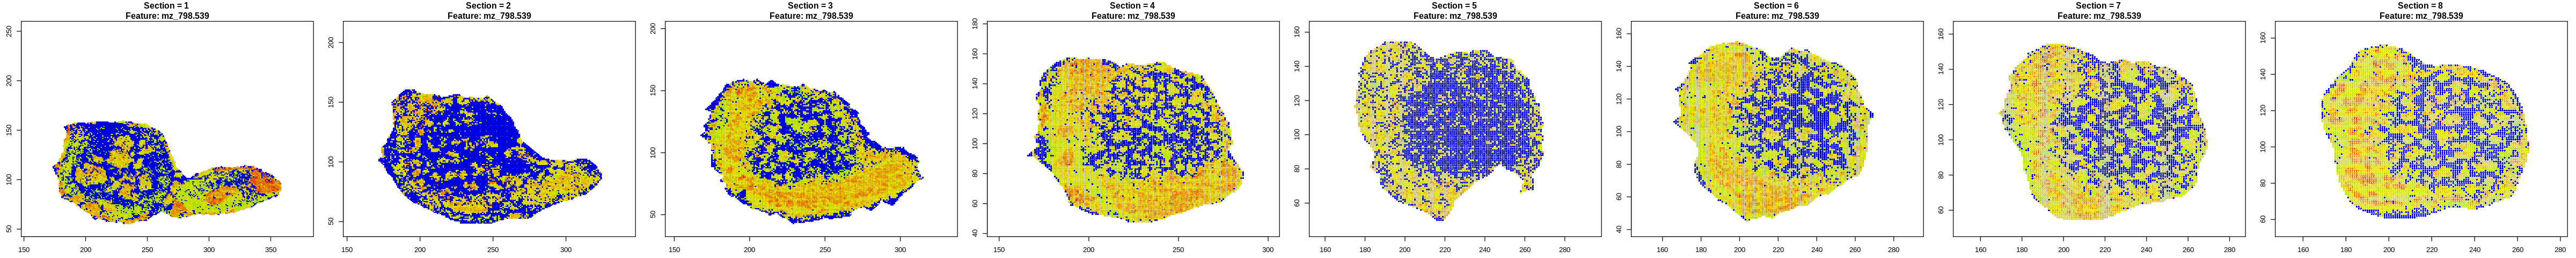

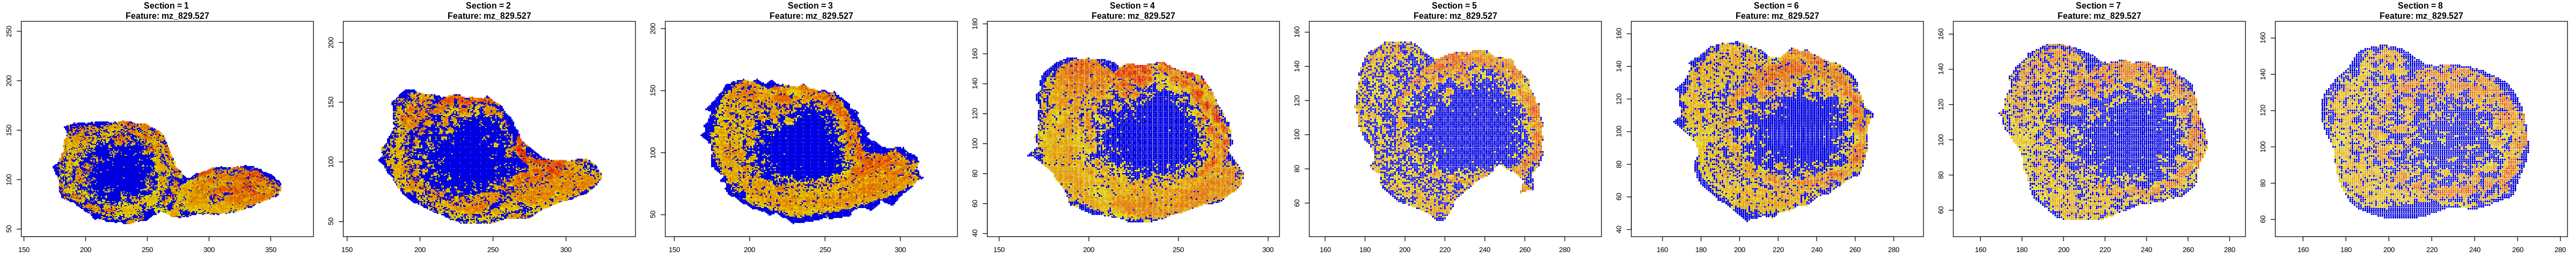

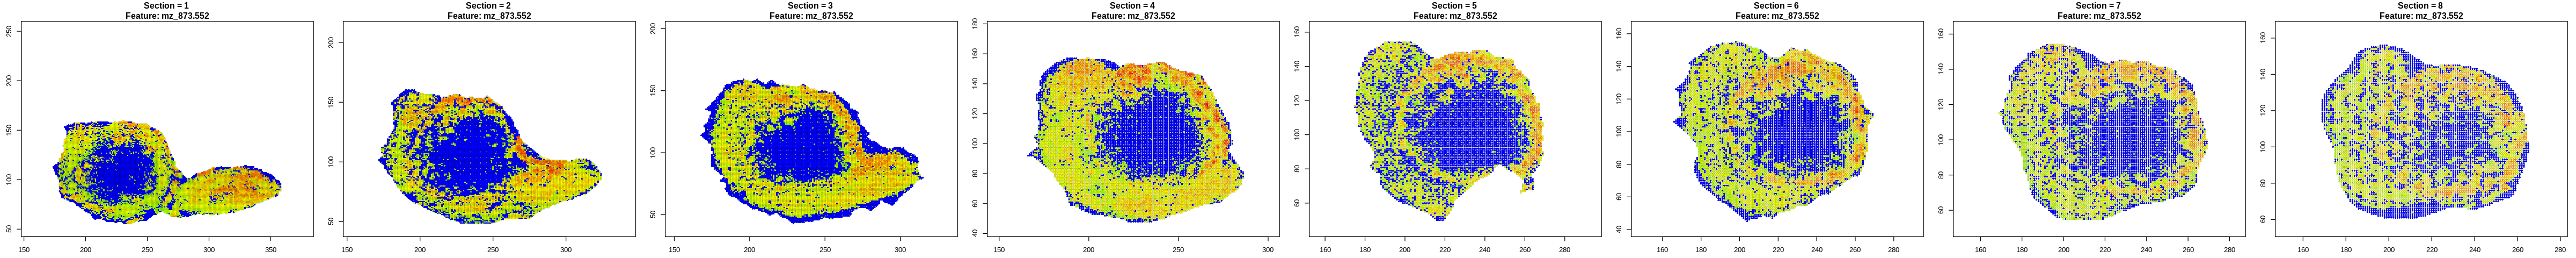

In [5]:
options(repr.plot.width = 40, repr.plot.height = 4)

Spatial_plot_multiple_subplots(Lipid_data, 
                        Meta_data, 
                        Feature = 5, 
                        Selected_sections = c(1,2,3,4,5,6,7,8),
                        use_global_scale = TRUE) # images share same min max values

Spatial_plot_multiple_subplots(Lipid_data, 
                        Meta_data, 
                        Feature = 10, 
                        Selected_sections = c(1,2,3,4,5,6,7,8),
                        use_global_scale = TRUE) # images share same min max values

Spatial_plot_multiple_subplots(Lipid_data, 
                        Meta_data, 
                        Feature = 25, 
                        Selected_sections = c(1,2,3,4,5,6,7,8),
                        use_global_scale = TRUE) # images share same min max values